## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [41]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import math
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

### Load dataset

In [42]:
with open('emails.txt', 'r') as inFile:
    email_texts = inFile.readlines()

### Preprocess data

In [43]:

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

raw_data = list()
for line in email_texts:
    word_list = line.strip().split()[1:]
    temp = list()
    for w in word_list:
        w = w.lower()
        for p in string.punctuation:
            w = w.replace(p, '')

        if(w not in stop_words and w not in string.digits):
            temp.append(ps.stem(w))

    raw_data.append({ 'label': line.strip().split()[0], 'data': temp })

df = pd.DataFrame(raw_data)
# df

### Split data

In [44]:
df_data = df.sample(frac=1.0, random_state=69)
split_idx1 = math.ceil(0.6 * len(df))
split_idx2 = math.ceil(0.8 * len(df))

train_data_set = df_data[:split_idx1]
validate_data_set = df_data[split_idx1:split_idx2]
test_data_set = df_data[split_idx2:]

train_data_set.reset_index(inplace=True)
train_data_set = train_data_set.drop('index', axis=1)

validate_data_set.reset_index(inplace=True)
validate_data_set = validate_data_set.drop('index', axis=1)

test_data_set.reset_index(inplace=True)
test_data_set = test_data_set.drop('index',axis = 1)


### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

- Calculation of IDF on train data

In [45]:
train_data_idf = dict()
for line in train_data_set['data']:
    words = set(line)
    for w in words:
        if w not in train_data_idf:
            train_data_idf[w] = 1
        else:
            train_data_idf[w] = train_data_idf[w] + 1
no_of_docs = df.shape[0]
print(no_of_docs)
for key in train_data_idf:
    train_data_idf[key] = math.log(no_of_docs/(1+train_data_idf[key]))

# pd.DataFrame([train_data_idf])

5574


- Calculation of TF (Term frequency)

In [46]:
def calc_tf(line):
    """
    Fn calculates TF value of each word present in a sentence,
    passed as list of words (tokenized form)
    
    @params:
        line: list of words
    
    @return:
        dict: key as word, value as TF value
    """
    tf = dict()
    for key in train_data_idf:
        tf[key] = 0

    for w in line:
        if w in tf:
            tf[w] = tf[w] + 1

    for w in tf:
        if len(line) != 0:
            tf[w] = tf[w]/len(line)
    
    return tf

- TF-IDF function

In [47]:
def get_tf_idf(idf, data_set):
    """
    Fn calculates TF-IDF value of each word present in argument data_set,
    using IDF value passed as argument.

    @params:
        idf: 
            dict: key as word, value as IDF value
        data_set:
            list of object with keys as 'label':string 
            and 'data': list of word for each sentence
    
    @return:
        np array: list of 1D array as TF-IDF of each word in a sentence of data_set
    """
    tf_idf_dict = list()

    for line in data_set['data']:
        # if len(line) != 0:
        tf = calc_tf(line)
        for k in tf:
            tf[k] = tf[k] * idf[k]
        tf_idf_dict.append(tf)
        
    tf_idf = list()
    for d in tf_idf_dict:
        temp = list()
        for w in d:
            temp.append(d[w])
        tf_idf.append(temp)

    return np.array(tf_idf)

- Calculation of TF-IDF of all data set

In [48]:
tf_idf_train = get_tf_idf(train_data_idf, train_data_set)
tf_idf_test = get_tf_idf(train_data_idf, test_data_set)
tf_idf_validate = get_tf_idf(train_data_idf, validate_data_set)

- Similarity Functions

In [49]:
def cosine_sim(train_list, test_list):
    return dot(train_list, test_list)/(norm(train_list)*norm(test_list))


def euclidean_dist(train_list, test_list):
    return norm(train_list - test_list)


def manhattan_dist(train_list, test_list):
    return np.abs(train_list - test_list).sum()

In [50]:
def get_similarity_obj_list(sim_fn, data_set, tf_idf):
    """
    This function calculates similarities/distances for passed data_set using train_data_set.

    @params:
        sim_fn: int
            1 for Cosine Similarity
            2 for Eucledian Distance
            3 for Manhattan Distance
        data_set: list
            list of object with keys as 'label':string 
            and 'data': list of word for each sentence
        tf_idf: 2D list
            TF-IDF of passed data_set

    @return:
        list of object as,
            key : label, 
            value : list of tuples having (label, its similarity value) 
                    for each item in data_set
    """
    res = list()

    for x, data_item in data_set.iterrows():
        tmp_dict = dict()
        tmp_list = list()
        for y, train_data in train_data_set.iterrows():
            sim_val = 0
            if sim_fn == 1:
                sim_val = 1 - cosine_sim(tf_idf_train[y], tf_idf[x])
            elif sim_fn == 2:
                sim_val = euclidean_dist(tf_idf_train[y], tf_idf[x])
            else:
                sim_val = manhattan_dist(tf_idf_train[y], tf_idf[x])

            tmp_list.append((train_data['label'], sim_val))

        tmp_dict[data_item['label']] = sorted(tmp_list, key = lambda i : i[1])
        res.append(tmp_dict)

    return res
    

# def get_accuracy_ratio(k, sim_fn):
#     """
#     @params: k-value, similarity funtion selector
#     @return: accuracy ratio
#     """
#     test_train_cos_sim = get_similarity_obj_list(k, sim_fn)
#     right_count = 0
#     for res_data in test_train_cos_sim:
#         for label in res_data:
#             correct_ratio = 0
#             for arr_elem in res_data[label][:k]:
#                 if(arr_elem[0] == label):
#                     correct_ratio += 1
#             if(correct_ratio/k) >= 0.5:
#                 right_count += 1

#     return right_count/len(test_train_cos_sim)


def get_truth_predict_tuple_list(k, dict_list):
    """
    This Fn calculates predicted value using k-value
    @params: 
        k-value: int, 
        dict_list: list
            list of dict having key as label (truth value) and
            key as list of tuples having (label, similarity value

    @return: list of tuple as (truth value, predicted value)
    """
    resp = list()
    for res_data in dict_list:
        for label in res_data:
            ham_count = 0
            spam_count = 0
            # for arr_elem in res_data[label][:k]:
            for idx in range(k):
                arr_elem = res_data[label][idx]
                if(arr_elem[0] == 'spam'):
                    spam_count += 1
                else:
                    ham_count += 1

            if(spam_count > ham_count):
                resp.append((label, 'spam'))
            else:
                resp.append((label, 'ham'))
    return resp


In [51]:
def get_f1_score(k, dict_list):
    """
    @params: 
        k: int
            k-value,
        dict_list: list
            list of dict having key as label (truth value) and
            key as list of tuples having (label, similarity value
        
    @return: int
        f1 score value
    """
    tuple_list = get_truth_predict_tuple_list(k, dict_list)

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for it in tuple_list:
        if(it[0] == 'spam'):
            if(it[0] == it[1]):
                true_positive += 1
            else:
                false_negative += 1
        else:
            if(it[0] == it[1]):
                true_negative += 1
            else:
                false_positive += 1

    # return [[true_positive, false_negative], [false_positive, true_negative]]

    precision = 0
    if (true_positive + false_positive) != 0:
        precision = true_positive/float(true_positive + false_positive)

    recall = 0
    if (true_positive + false_negative) != 0:
        recall = true_positive/float(true_positive + false_negative)

    f1_score = 0
    if (precision + recall) != 0:
        f1_score = 2 * ((precision * recall)/float(precision + recall))
    
    return f1_score


In [52]:
def get_accuracy_score(k, dict_list):
    """
    @params: 
        k: int
            k-value,
        dict_list: list
            list of dict having key as label (truth value) and
            key as list of tuples having (label, similarity value
        
    @return: int
        accuracy score
    """
    tuple_list = get_truth_predict_tuple_list(k, dict_list)

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for it in tuple_list:
        if(it[0] == 'spam'):
            if(it[0] == it[1]):
                true_positive += 1
            else:
                false_negative += 1
        else:
            if(it[0] == it[1]):
                true_negative += 1
            else:
                false_positive += 1

    # return [[true_positive, false_negative], [false_positive, true_negative]]

    # precision = 0
    # if (true_positive + false_positive) != 0:
    #     precision = true_positive/float(true_positive + false_positive)

    # recall = 0
    # if (true_positive + false_negative) != 0:
    #     recall = true_positive/float(true_positive + false_negative)

    # f1_score = 0
    # if (precision + recall) != 0:
    #     f1_score = 2 * ((precision * recall)/float(precision + recall))

    accuracy_score = (true_positive + true_negative)/float(true_negative + true_positive + false_negative + false_positive)
    
    return accuracy_score

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***


In our dataset, we see that we get the best accuracy scores by using **cosine simmilarity**, in comparison of euclidean and manhattan distances.

The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean/Manhattan distances, they could still have a smaller angle between them. Smaller the angle, higher the cosine similarity.

Cosine similarity is calculated using only the dot product and magnitude of each vector, and is therefore affected only by the terms the two vectors have in common.

- Pros:
    Both continuous and categorical variables can be used.
- Cons:
    Doesn’t work efficiently with nominal data.
- Significant Application Area:
    Text Mining

**Euclidean Distance** is the ordinary distance between a pair of objects which can be measured with the help of a ruler.

- Pros:
    Easy to implement. Easy to test.

- Cons:
    The variables which have the largest value greatly influence the result. Doesn’t work efficiently with image data.

- Significant Application Area:
    Application involving Interval Data, DNA Analysis, Health Psychology Analysis

**Manhattan Distance** is the distance between a pair of points which is measured along the axes at 90 degrees or right angles.

- Pros
    Easy to generalize into higher dimensions.

- Cons:
    Doesn’t work efficiently with image data. Can’t be used to classify documents.

- Significant Application Area:
    Integrated Circuits

***3. Report Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score in a tabular form***

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 score vs k.***

In [53]:
k_val_range = [1,3,5,7,11,17,23,28]
f1_val_list_cos_sim = list()
f1_val_list_euc_dist = list()
f1_val_list_man_dist = list()

validate_train_sim_dict = get_similarity_obj_list(1, validate_data_set, tf_idf_validate)
validate_train_euc_dict = get_similarity_obj_list(2, validate_data_set, tf_idf_validate)
validate_train_man_dict = get_similarity_obj_list(3, validate_data_set, tf_idf_validate)

for k in k_val_range:
    f1_val_list_cos_sim.append(get_f1_score(k, validate_train_sim_dict))
    f1_val_list_euc_dist.append(get_f1_score(k, validate_train_euc_dict))
    f1_val_list_man_dist.append(get_f1_score(k, validate_train_man_dict))



/var/folders/c9/1760g61j5qv_09twk6bg40kh0000gn/T/ipykernel_74822/1941715078.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return dot(train_list, test_list)/(norm(train_list)*norm(test_list))


- Graph plotting

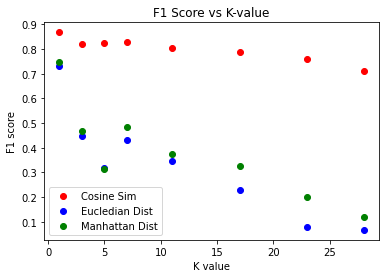

In [54]:
plt.xlabel('K value')
plt.ylabel('F1 score')
plt.title("F1 Score vs K-value")
plt.scatter(k_val_range, f1_val_list_cos_sim, label='Cosine Sim', color='red')
plt.scatter(k_val_range, f1_val_list_euc_dist, label='Eucledian Dist', color='blue')
plt.scatter(k_val_range, f1_val_list_man_dist, label='Manhattan Dist', color='green')
plt.legend()
plt.show()

- Calculation of optimal k-value

In [55]:
optimal_k_val = 0
max_f1 = 0
optimal_sim_fn = 1

for i,v in enumerate(f1_val_list_cos_sim):
    if max_f1 < v and k_val_range[i] != 1:
        max_f1 = v
        optimal_k_val = k_val_range[i]
        optimal_sim_fn = 1

for i,v in enumerate(f1_val_list_euc_dist):
    if max_f1 < v and k_val_range[i] != 1:
        max_f1 = v
        optimal_k_val = k_val_range[i]
        optimal_sim_fn = 2

for i,v in enumerate(f1_val_list_man_dist):
    if max_f1 < v and k_val_range[i] != 1:
        max_f1 = v
        optimal_k_val = k_val_range[i]
        optimal_sim_fn = 3


In [56]:
f1_score_manual = get_f1_score(optimal_k_val, get_similarity_obj_list(optimal_sim_fn, test_data_set, tf_idf_test))
accuracy_score_manual = get_accuracy_score(optimal_k_val, get_similarity_obj_list(optimal_sim_fn, test_data_set, tf_idf_test))

/var/folders/c9/1760g61j5qv_09twk6bg40kh0000gn/T/ipykernel_74822/1941715078.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return dot(train_list, test_list)/(norm(train_list)*norm(test_list))


### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [ ]:
knn = KNeighborsClassifier(optimal_k_val, metric="cosine")
knn.fit(tf_idf_train, train_data_set['label'])
pred = knn.predict(tf_idf_test)
f1_score_skl = metrics.f1_score(test_data_set['label'], pred, pos_label='spam')
accuracy_score_skl = metrics.accuracy_score(test_data_set['label'], pred)

***Compare both the models result.***

In [ ]:
print("Manually calculated F1 score", f1_score_manual)
print("SKLearn calculated F1 score", f1_score_skl)
print("Manually calculated F1 score", accuracy_score_manual)
print("SKLearn calculated F1 score", accuracy_score_skl)

Manually calculated F1 score 0.8644067796610169
SKLearn calculated F1 score 0.869198312236287
Manually calculated F1 score 0.9712746858168761
SKLearn calculated F1 score 0.9721723518850988


***What is the time complexity of training using KNN classifier?***

<p>
For training data set, the time complexity of KNN is O(1) as no actual training is done, KNN is a brute force algorithm
</p>

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

<p>
Time complexity while testing is O(n*d) where <br>
n is the number of emails <br>
d is the number of different words available <br>

A classifier is linear if its decision boundary on the feature space is a linear function: positive and negative examples are separated by an hyperplane.<br> <br>

With KNN you don't have an hyperplane in general. Imagine some dense region of positive points. The decision boundary to classify test instances around those points will look like a curve - not a hyperplane, thus KNN is not a linear classifier
<br>
KNN classifier can learn any boundary.
</p>

**Why accuracy alone is not sufficient to evaluate the model. Why we need precision/recall/f1-score?**

- We can see that accuracy alone does not paint the whole picture. We cannot know how well the model performs if e are more concerned with either false positives or false negatives. In such senario only accuracy fails to summarize the effectiveness of the model. 
- When we have imbalanced data and we need high true positives, precision is prefered metrics. Because precision has no false negative in its formula, which can impact the positive rate, it can help us to identity how accurate our model is in identifing true positive cases over all positive cases.
- When we are more concerned with false negatives, recall is a better metrics to use.
- There is a tradeoff between precision and recall. As precision increases, recall decreases and vice versa 
- We need a tradeoff between Precision and Recall. We first need to decide which is more important for our classification problem. There are also a lot of situations where both precision and recall are equally important. If we want to create a classification model with the optimal balance of recall and precision, then we try to maximize the F1 score.
- The F1 score is the harmonic mean of precision and recall, taking both metrics into account